In [1]:
import json
import os
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(os.path.join(sys.path[0], '../tooling/'))
from mylogging import nanodet_parse

Collect training results

In [3]:
location = '../results/train_nanodet/'
logs = glob.glob(os.path.join(location,'*logs.txt'))
names = [strng[len(location):-9] for strng in logs] 

In [4]:
train_scores = []
for path in logs:
    train_scores.append(nanodet_parse(path))

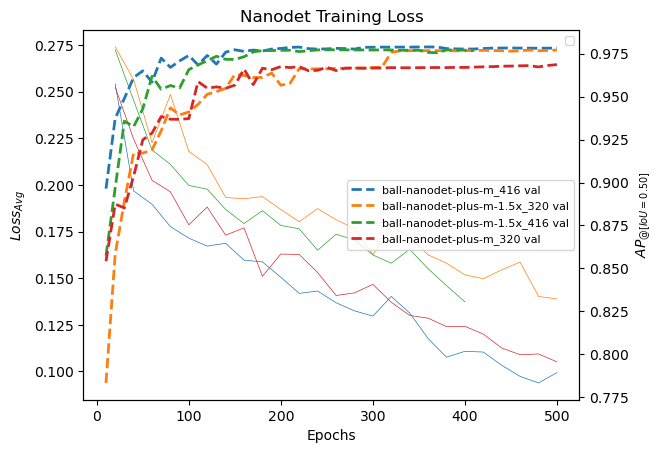

In [5]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax1 = plt.subplots()
plt.title("Nanodet Training Loss")
ax2 = ax1.twinx()

leg_list_train = []
leg_list_val = []
for i, train_score in enumerate(train_scores):
    ax1.plot(train_score[0], train_score[1], linestyle='-', color=colors[i], linewidth=0.5)
    #leg_list_train.append(names[i] + " train")
    ax2.plot(train_score[2], train_score[3], linestyle='--', color=colors[i], linewidth=2)
    leg_list_val.append(names[i] + " val")

ax1.legend(leg_list_train, loc="upper right", fontsize="8", ncol=1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("$" + "Loss_{Avg}" + "$")
ax2.legend(leg_list_val, loc="center right", fontsize="8", ncol=1)
ax2.set_ylabel('$' + 'AP_{@[IoU=0.50]}' + '$')
plt.show()

Performance results

In [6]:
location = '../results/train_nanodet/'
dataset = 'coco_validation_sml_01_False_matchdrill'
load_dirs = glob.glob(os.path.join(location,'*.json'))
names = [strng[len(location):-11] for strng in load_dirs] 
model_score = []
model_lats = []

for i, path in enumerate(load_dirs):
    with open(path, 'r') as input_file:
        result_dict = json.load(input_file)
    model_score.append(result_dict[names[i]][dataset]['AP_{@[IoU=0.50:0.95]-all}'])
    model_lats.append(result_dict[names[i]][dataset]['latency'])

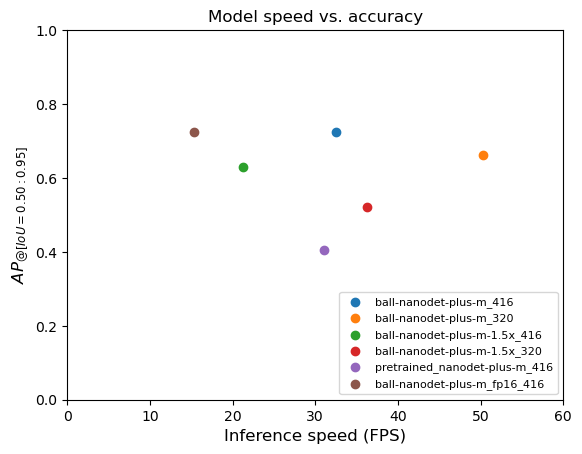

In [7]:
for i, _ in enumerate(names):
    plt.scatter(model_lats[-i-1], model_score[-i-1])

plt.title("Model speed vs. accuracy")
plt.legend(names[::-1], loc="lower right", fontsize="8", ncol=1)
plt.xlabel('Inference speed (FPS)', fontsize="12")
plt.xlim([0, 60])
plt.ylabel('$' + 'AP_{@[IoU=0.50:0.95]}' + '$', fontsize="12")
plt.ylim([0.0, 1])
plt.show()